# Modeling Saturation Properties of Methane

<br>

This notebook aims to create regression models to predict saturation properties of methane, based on experimental data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
import sys
sys.path.append('../modules/')
from utils_functions import utils
from validation import validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

############################################# IMPORTANT DEFINITIONS ###########################################################
RANDOM_SEED = 1002
warnings.filterwarnings('ignore')
MODEL_SAVE_FILEPATH = '../models'
SATURATION_DATA_FILEPATH = '../data'
SATURATION_FILENAME = 'SaturationProperties.xlsx'
FLUID_CODE = 1 # methane
basic = utils()
validation = validate()

## 1. Vapor Pressure

In [2]:
# import data
data = basic.load_filter_data(vapor_fraction = 0, 
                              fluid_code = FLUID_CODE, 
                              complete_filepath = os.path.join(SATURATION_DATA_FILEPATH, SATURATION_FILENAME))
data.head()

,t,p,x,v,h,s
0,90.694,0.011696,0,0.035534,-1.152200,-0.011389
1,100.000,0.034376,0,0.036554,-0.646020,-0.006086
2,105.000,0.056377,0,0.037143,-0.370970,-0.003410
3,110.000,0.088130,0,0.037768,-0.093257,-0.000837
4,115.000,0.132210,0,0.038431,0.187500,0.001644


### 1.1 Vapor Pressure Model Validation

[INFO] Mean Absolute Error: 0.0000
[INFO] Root Mean Squared Error: 0.0028
[INFO] R2 Score: 1.0000


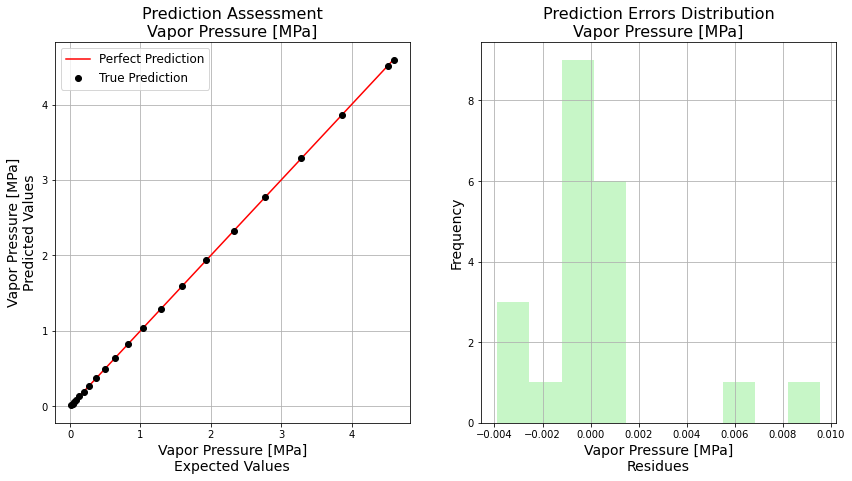

In [3]:
validation.vapor_pressure(data, FLUID_CODE)

### 1.2. Saturation Temperature Model Validation

[INFO] Mean Absolute Error: 0.0005
[INFO] Root Mean Squared Error: 0.0218
[INFO] R2 Score: 1.0000


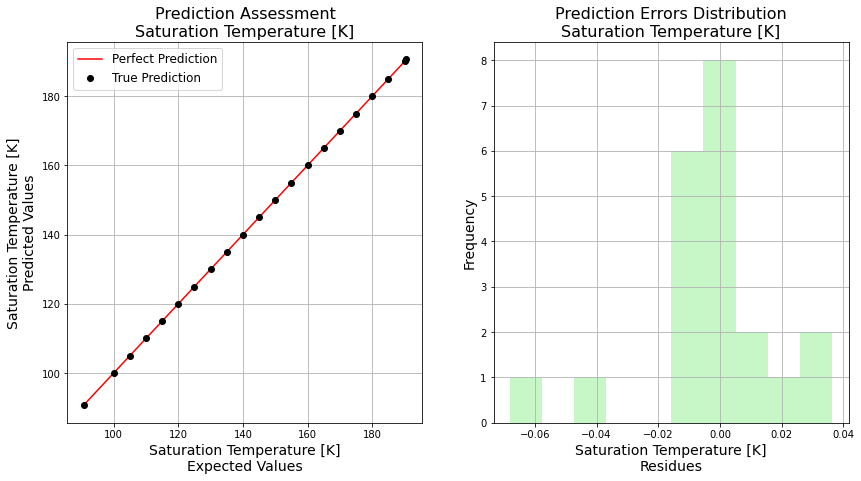

In [4]:
validation.sat_temperature(data, FLUID_CODE)

## 2. Saturated Liquid Specific Volume

In [5]:
# select predictors and target
x = data[['t', 'p']]
y = data[['v']]

Text(0, 0.5, 'specific_volume')

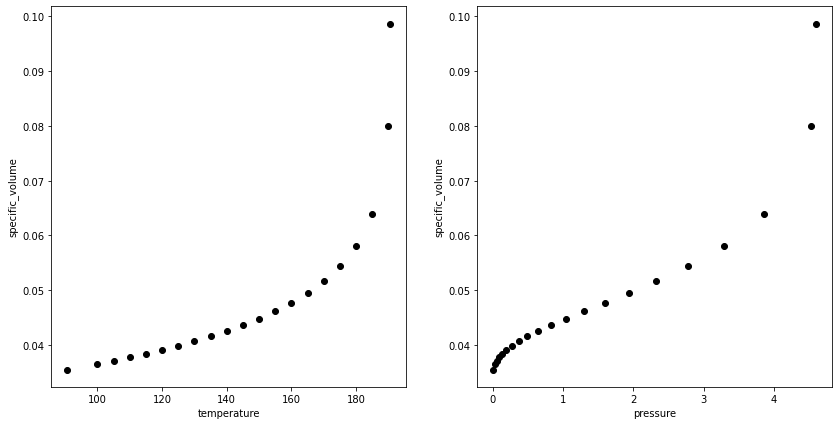

In [6]:
# explore correlations between predictors and target
fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(1,2,1)
plt.plot(x['t'], y, 'ko')
plt.xlabel('temperature')
plt.ylabel('specific_volume')

ax2 = fig.add_subplot(1,2,2)
plt.plot(x['p'], y, 'ko')
plt.xlabel('pressure')
plt.ylabel('specific_volume')

Text(0, 0.5, 'specific_volume')

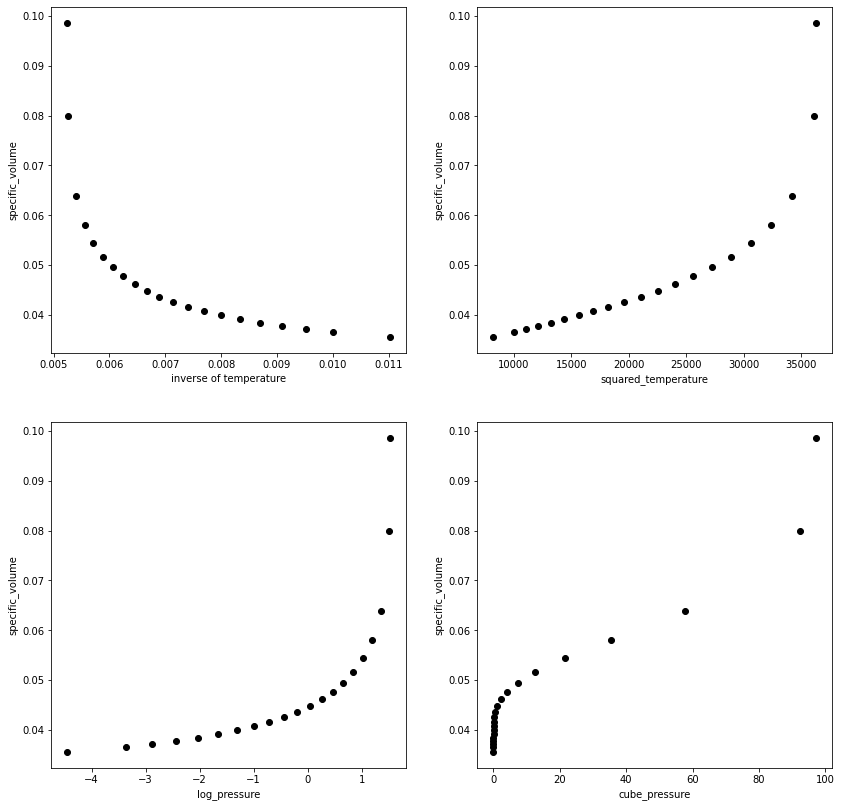

In [7]:
# feature engineering
x['1/t'] = 1/x['t']
x['t**2'] = x['t']**2
x['log_p'] = np.log(x['p'])
x['p**3'] =x['p']**3

fig = plt.figure(figsize = (14,14))
ax1 = fig.add_subplot(2,2,1)
plt.plot(x['1/t'], y, 'ko')
plt.xlabel('inverse of temperature')
plt.ylabel('specific_volume')

ax2 = fig.add_subplot(2,2,2)
plt.plot(x['t**2'], y, 'ko')
plt.xlabel('squared_temperature')
plt.ylabel('specific_volume')

ax3 = fig.add_subplot(2,2,3)
plt.plot(x['log_p'], y, 'ko')
plt.xlabel('log_pressure')
plt.ylabel('specific_volume')

ax4 = fig.add_subplot(2,2,4)
plt.plot(x['p**3'], y, 'ko')
plt.xlabel('cube_pressure')
plt.ylabel('specific_volume')

In [13]:
def model_training_selection(x, y, model_name):
    """
    performs model training, cross validation and selection using
    Leave One Out cross validation. The models tested are LinearRegression or DecisionTrees
    
    args: predictors arrays and target array, string containing model name
    
    returns: save best model and average performance index
    """
    
    # create classes objects instances
    model_linear = LinearRegression()
    model_tree = DecisionTreeRegressor(random_state = RANDOM_SEED)
    
    # create test sets by using the mean between points (assuming linear variations)
    x_test, y_test = x.rolling(2).mean().dropna(), y.rolling(2).mean().dropna()
          
    # training model
    model_linear = model_linear.fit(x, y)
    model_tree = model_tree.fit(x, y)

    # making predictions
    yhat_lin = model_linear.predict(x_test)
    yhat_tree = model_tree.predict(x_test)
       
    # calculate decisory index
    mae_lin = mean_absolute_error(y_test, yhat_lin)
    mae_tree = mean_absolute_error(y_test, yhat_tree)
        
    # print performance indexes for LinearRegression
    print('[INFO] Linear Regression MAE: %.4f'%(mae_lin))
    print('[INFO] Linear Regression RMSE: %.4f'%(np.sqrt(mean_squared_error(y_test, yhat_lin))))
    print('[INFO] Linear Regression R2: %.4f'%(r2_score(y_test, yhat_lin)))
    print('\n')
    print('[INFO] Decision Tree Regression MAE: %.4f'%(mae_tree))
    print('[INFO] Decision Tree Regression RMSE: %.4f'%(np.sqrt(mean_squared_error(y_test, yhat_tree))))
    print('[INFO] Decision Tree Regression R2: %.4f'%(r2_score(y_test, yhat_tree)))
    
    # select model based on MAE
    if mae_lin <= mae_tree:
        print('[INFO] Saving best model - Linear Regression')
        joblib.dump(model_linear, os.path.join(MODEL_SAVE_FILEPATH, 'linearmodel_'+model_name))
    else:
        print('[INFO] Saving best model - Decision Tree Regressor')
        joblib.dump(model_tree, os.path.join(MODEL_SAVE_FILEPATH, 'decisiontree_'+model_name))

In [14]:
model_training_selection(x, y, 'sat_liquid_volume'+str(FLUID_CODE)+'.m')

[INFO] Linear Regression MAE: 0.0005
[INFO] Linear Regression RMSE: 0.0006
[INFO] Linear Regression R2: 0.9981


[INFO] Decision Tree Regression MAE: 0.0016
[INFO] Decision Tree Regression RMSE: 0.0029
[INFO] Decision Tree Regression R2: 0.9491
[INFO] Saving best model - Linear Regression
